In [1]:
import os
import re
import warnings
import textwrap

from datetime import datetime

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm.auto import tqdm
from tqdm import tqdm_notebook
# tqdm_notebook().pandas()

sns.set(style="ticks", palette="muted", color_codes=True)

warnings.filterwarnings("ignore")

plt.rcParams['axes.labelsize'] = 15
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['font.weight'] = 'bold'

In [2]:
def wrap_text(text):
    return textwrap.fill(text, width=85)

In [3]:
def ingest_file(filename):
    
    df = (
        pd.read_csv(filename)
        .assign(date=lambda x: (x['date']
                                .replace(r'·', "", regex=True)
                                .apply(pd.to_datetime)))
    )

    return df

In [4]:
folder_path="dataset/"

df = (
    pd.concat((ingest_file(filename=folder_path+filename) for filename in tqdm(os.listdir(folder_path))),
              ignore_index=True)
    .sort_values('date', ascending=False)
    .drop_duplicates(ignore_index=True)
)

  0%|          | 0/116 [00:00<?, ?it/s]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65793 entries, 0 to 65792
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype              
---  ------    --------------  -----              
 0   link      65793 non-null  object             
 1   text      65793 non-null  object             
 2   date      65793 non-null  datetime64[ns, UTC]
 3   Likes     65793 non-null  int64              
 4   Comments  65793 non-null  int64              
dtypes: datetime64[ns, UTC](1), int64(2), object(2)
memory usage: 2.5+ MB


In [6]:
df.duplicated().sum()

0

In [7]:
df.head()

,link,text,date,Likes,Comments
0,https://twitter.com/juliet_gough/status/174158...,It was fantastic service onboard. I'm so impre...,2023-12-31 22:23:00+00:00,0,0
1,https://twitter.com/theamaeestales/status/1741...,@qrsupport is there a problem with your app? I...,2023-12-31 19:51:00+00:00,0,0
2,https://twitter.com/rvvaradan/status/174143019...,I have reported the incident. Hoping to get a ...,2023-12-31 12:04:00+00:00,1,3
3,https://twitter.com/ManojKa15016293/status/174...,Not settling dues for more than 3 years . Appr...,2023-12-31 10:19:00+00:00,2,2
4,https://twitter.com/nkonialidis/status/1741377...,Kindly communicate better about the upcoming r...,2023-12-31 08:34:00+00:00,1,3


In [8]:
for year in range(2017, 2024, 1):

    start_date = df.loc[df['date'].dt.year==year, 'date'].dt.date.min()
    end_date = df.loc[df['date'].dt.year==year, 'date'].dt.date.max()

    print(f"Year {year}: Start date: {start_date}, End Date:{end_date}")

Year 2017: Start date: 2017-08-09, End Date:2017-12-31
Year 2018: Start date: 2018-01-01, End Date:2018-12-31
Year 2019: Start date: 2019-01-01, End Date:2019-12-31
Year 2020: Start date: 2020-01-01, End Date:2020-12-31
Year 2021: Start date: 2021-01-01, End Date:2021-12-31
Year 2022: Start date: 2022-01-01, End Date:2022-12-31
Year 2023: Start date: 2023-01-01, End Date:2023-12-31


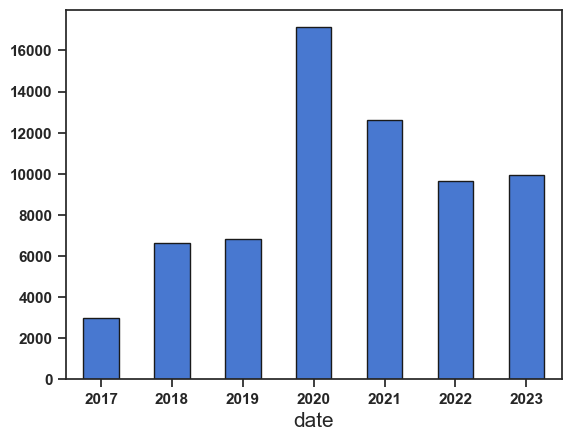

In [9]:
(
    df['date']
    .dt
    .year
    .value_counts()
    .sort_index()
    .plot(kind='bar', edgecolor='k', rot=0)
);

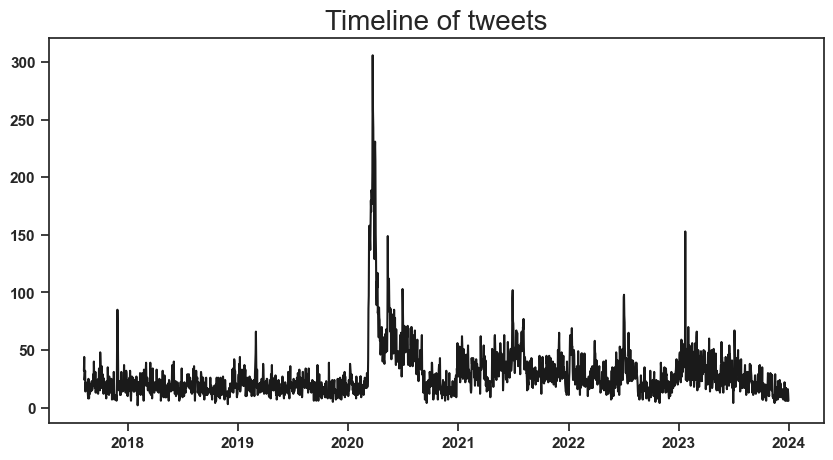

In [10]:
ax = (
    df.groupby(df['date'].dt.date).size()
    .plot(figsize=(10, 5), c='k', title='Timeline of tweets')
)

ax.set_xlabel("");

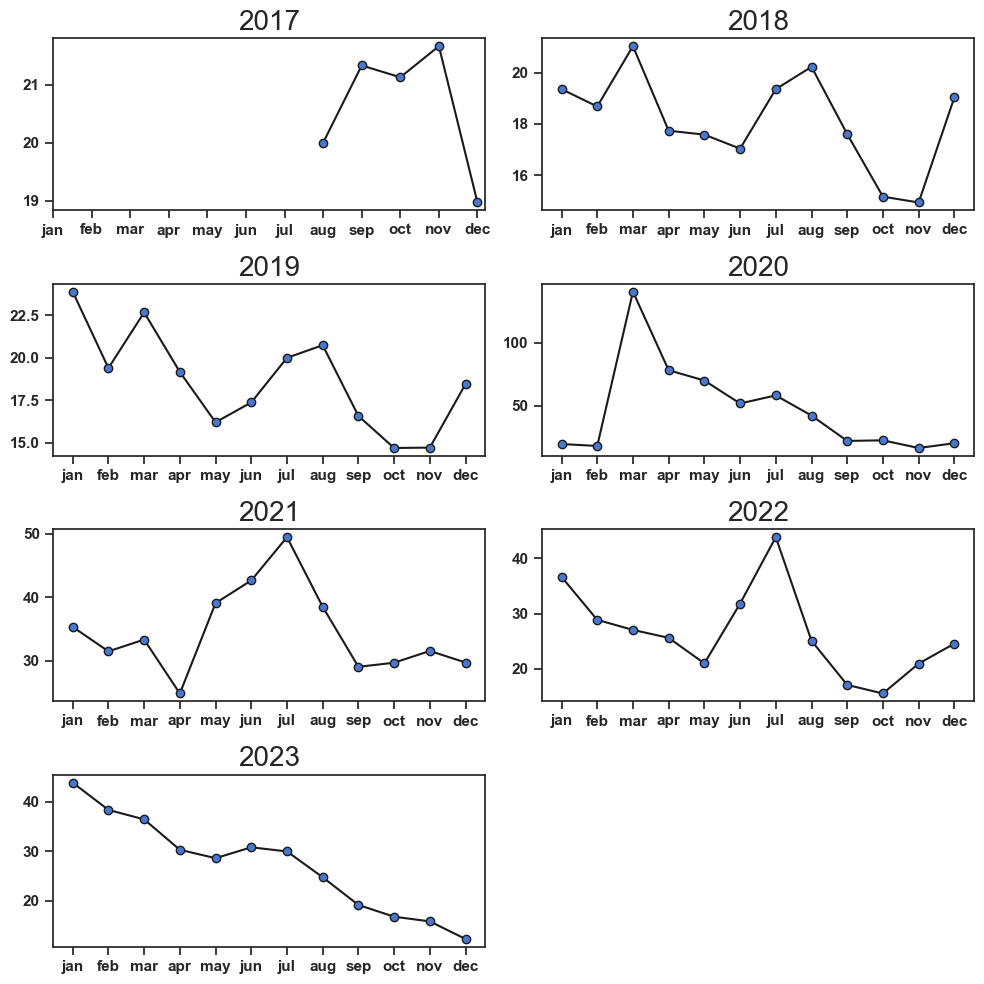

In [11]:
months=['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 
        'oct', 'nov', 'dec']

fig, axes = plt.subplots(4, 2, figsize=(10, 10), tight_layout=True)

for year, ax in zip(range(2017, 2024, 1), axes.flatten()):

    ax = (
        df.loc[df['date'].dt.year==year]
        .assign(month=df['date'].dt.month)
        .groupby([df['date'].dt.date, 'month']).size()
        .groupby('month').mean()
        .plot(ax=ax, marker='o', mfc='b', c='k')
    )

    ax.set_title(year)
    ax.set_xlabel("")
    ax.set_xticks(ticks=range(1, 13, 1), labels=months)

axes.flatten()[-1].set_axis_off();

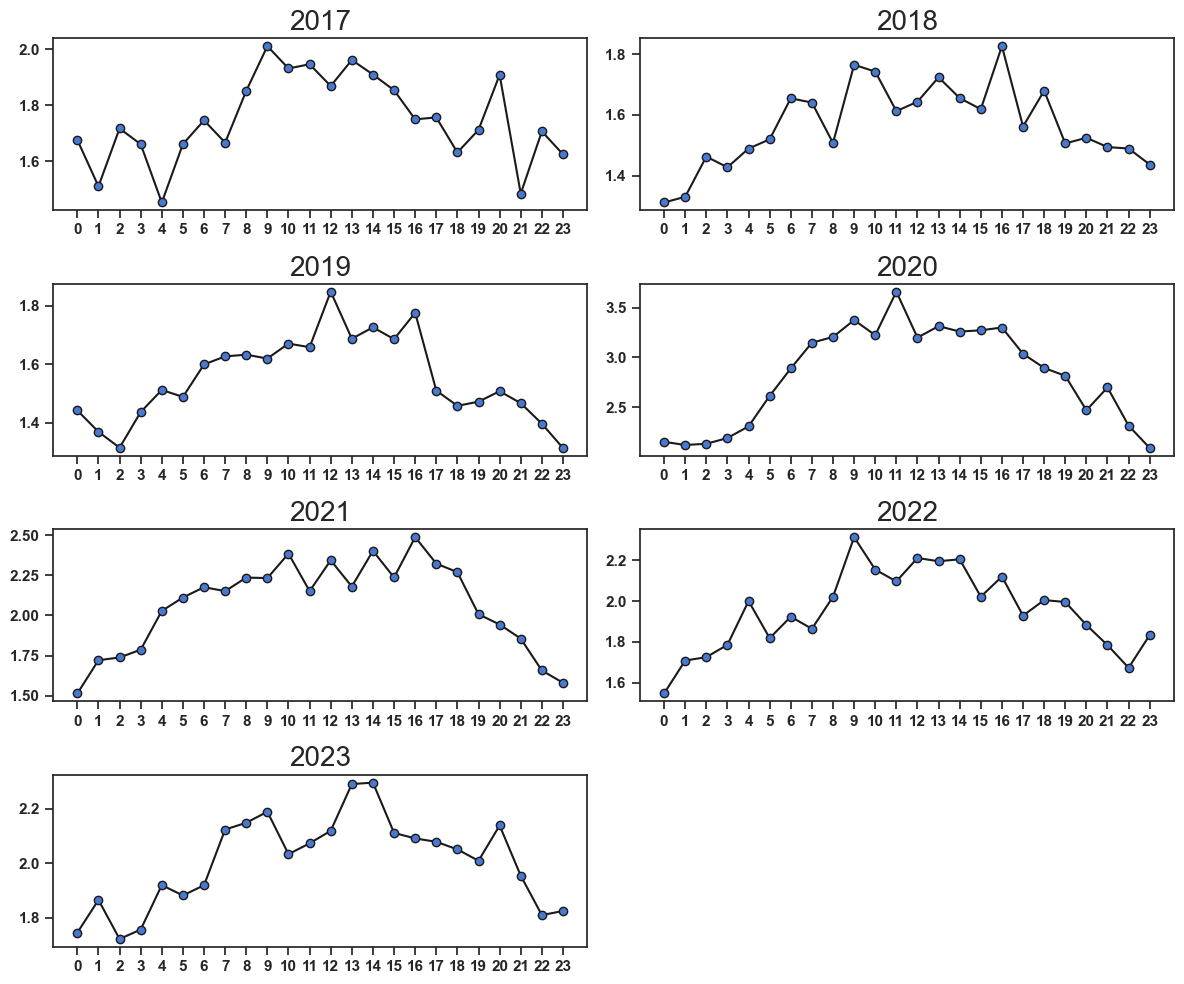

In [12]:
fig, axes = plt.subplots(4, 2, figsize=(12, 10), tight_layout=True)

for year, ax in zip(range(2017, 2024, 1), axes.flatten()):

    ax = (
        df.loc[df['date'].dt.year==year]
        .assign(hour=df['date'].dt.hour)
        .groupby([df['date'].dt.date, 'hour']).size()
        .groupby('hour').mean()
        .plot(ax=ax, marker='o', mfc='b', c='k')
    )

    ax.set_title(year)
    ax.set_xlabel("")
    ax.set_xticks(range(24))

axes.flatten()[-1].set_axis_off();

In [13]:
def extract_pattern(text, pattern):    
    # Use re.findall to extract all matches in the text
    handles = re.findall(pattern, text)
    
    return handles

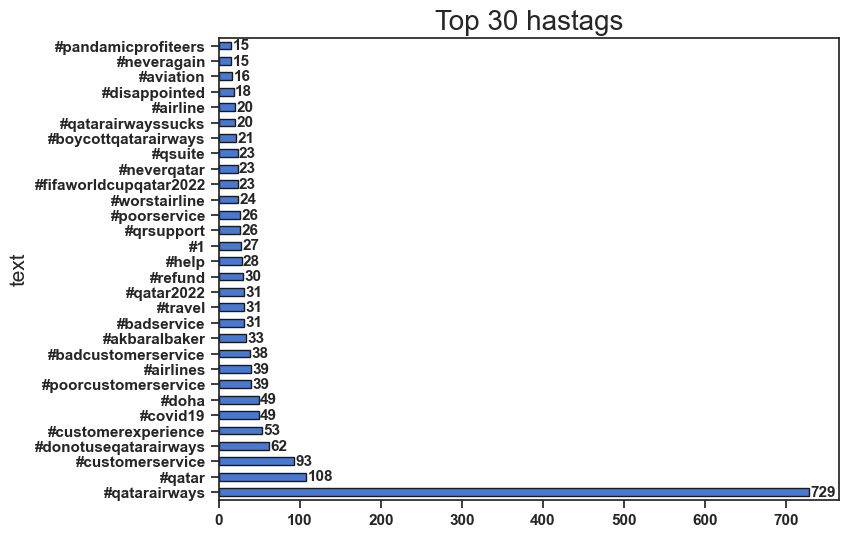

In [14]:
ax = (
    df['text'].str.lower()
    .apply(extract_pattern, pattern=r'(#\w+)')
    .explode()
    .dropna()
    .str.replace(r'\.$|,$|_', "", regex=True)
    .value_counts()
    .nlargest(30)
    .plot(kind='barh', edgecolor='k', figsize=(8, 6), title="Top 30 hastags")
)

for c in ax.containers:
    labels = [v for v in c.datavalues]    
    ax.bar_label(c, labels=labels, label_type="edge", fontweight = "bold", 
                 padding=1, fontsize=11)

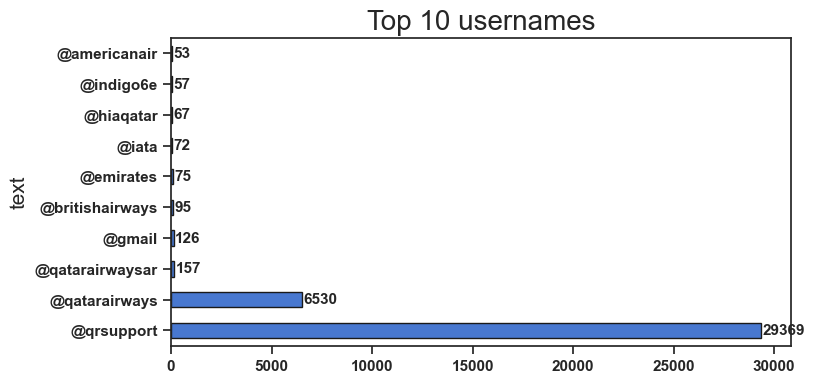

In [15]:
ax = (
    df['text'].str.lower()
    .apply(extract_pattern, pattern=r'(@\w+)')
    .explode()
    .dropna()
    .str.replace(r'\.$|,$|_', "", regex=True)
    .value_counts()
    .nlargest(10)
    .plot(kind='barh', edgecolor='k', figsize=(8, 4), title="Top 10 usernames")
)

for c in ax.containers:
    labels = [v for v in c.datavalues]    
    ax.bar_label(c, labels=labels, label_type="edge", fontweight = "bold", 
                 padding=1, fontsize=11)

In [16]:
# Create new column with all hashtags
df["hashtags"] = df['text'].apply(extract_pattern, pattern=r'(#\w+)')

In [17]:
df.loc[df['hashtags'].apply(lambda x: len(x)).ne(0)].tail(5)

,link,text,date,Likes,Comments,hashtags
65654,https://twitter.com/ching_snipz/status/8966925...,@qrsupport DO NOT CONTRIBUTE TO HUMAN RIGHTS A...,2017-08-13 11:19:00+00:00,0,0,[#FreeSaeed]
65655,https://twitter.com/ching_snipz/status/8966894...,@qrsupport PLEASE DO NOT CONTRIBUTE TO HUMAN R...,2017-08-13 11:06:00+00:00,7,0,[#FreeSaeed]
65656,https://twitter.com/TashaStaffieri/status/8966...,@qrsupport I'm returning from Bali with my new...,2017-08-13 10:35:00+00:00,0,1,[#justasking]
65755,https://twitter.com/Topsy89/status/89555068683...,@qrsupport any chance of being able to log int...,2017-08-10 07:41:00+00:00,0,1,"[#travelissues, #airlines, #BHX]"
65790,https://twitter.com/cpt_t88/status/89522710036...,"@qrsupport pls consider #Pune for new route, ...",2017-08-09 10:15:00+00:00,1,0,[#Pune]


# Sentiment Classification

In [18]:
# https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest

from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
from scipy.special import softmax


MODEL = "cardiffnlp/twitter-roberta-base-sentiment-latest"

tokenizer = AutoTokenizer.from_pretrained(MODEL)
config = AutoConfig.from_pretrained(MODEL)

# PT
model = AutoModelForSequenceClassification.from_pretrained(MODEL)
tokenizer.save_pretrained(MODEL)
model.save_pretrained(MODEL)

In [19]:
# Preprocess text (username and link placeholders)
def preprocess(text):
    new_text = []
 
    for t in text.split(" "):
        t = '@user' if t.startswith('@') and len(t) > 1 else t
        t = 'http' if t.startswith('http') else t
        new_text.append(t)
    return " ".join(new_text)

# Predict Sentiment
def predict_sentiment(text):

    encoded_inputs = tokenizer(text, 
                               padding=True, 
                               truncation=True, 
                               return_tensors="pt")
    
    outputs = model(**encoded_inputs)
    scores=softmax(outputs[0].detach().numpy(), axis=1)
    ranking = np.argsort(scores)[:, ::-1]
    
    sentiments = [{"label": config.id2label[rank[0]], "score":scores[i][rank[0]]} 
                  for i, rank in enumerate(ranking)]

    return sentiments

In [20]:
text = "Covid cases are increasing fast!"
predict_sentiment(text)

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


[{'label': 'negative', 'score': 0.7235765}]

In [21]:
# Positive
text=df.loc[0, "text"]
print(wrap_text(text))
print()
predict_sentiment(text)

It was fantastic service onboard. I'm so impressed. Thank you!!



[{'label': 'positive', 'score': 0.9895235}]

In [22]:
# Negative
text=df.loc[25, "text"]
print(wrap_text(text))
print()
predict_sentiment(text)

@qrsupport am trying to book a ticket with you but an hour later I still can’t sign
up to your Privilege club. Email verified. But when I hit update password, nothing
happens every time. Tried online & it said something is wrong: I should phone Qatar.
I just want to buy a ticket.



[{'label': 'negative', 'score': 0.87767094}]

In [23]:
# Neutral
text=df.loc[4, "text"]
print(wrap_text(text))
print()
predict_sentiment(text)

Kindly communicate better about the upcoming rebooking.



[{'label': 'neutral', 'score': 0.82786316}]

In [24]:
# Define the batch size
batch_size = 64

# Load the tweets into memory
tweets = df.loc[:, 'text'].to_list() 
proprocess_tweets = [preprocess(text) for text in tweets]

# Classify the tweets in batches
results = []
for i in tqdm(range(0, len(proprocess_tweets), batch_size)):
    
    batch = proprocess_tweets[i:i+batch_size]
    sentiments = predict_sentiment(batch)
    results.extend(sentiments)

  0%|          | 0/1029 [00:00<?, ?it/s]

In [25]:
df['sentiment']=results

In [26]:
# Positive
df.loc[df['sentiment'].apply(lambda x: x['label']=='positive'), ['text', 'sentiment']]

,text,sentiment
0,It was fantastic service onboard. I'm so impre...,"{'label': 'positive', 'score': 0.9895235}"
3,Not settling dues for more than 3 years . Appr...,"{'label': 'positive', 'score': 0.83495665}"
7,This is my first time traveling with your airl...,"{'label': 'positive', 'score': 0.9530944}"
8,Thank you. I've sent the file ref#.,"{'label': 'positive', 'score': 0.70994127}"
26,I’m really humble & honored to receive a feedb...,"{'label': 'positive', 'score': 0.98282176}"
...,...,...
65756,I hope inshallah soon QR will fly back there,"{'label': 'positive', 'score': 0.8066471}"
65777,@qrsupport What's the cost to change my flight...,"{'label': 'positive', 'score': 0.8572432}"
65786,My pleasure Qatar Airways,"{'label': 'positive', 'score': 0.9719187}"
65791,@qrsupport Welcome to the wonderful world of T...,"{'label': 'positive', 'score': 0.97937185}"


In [27]:
# Neutral
df.loc[df['sentiment'].apply(lambda x: x['label']=='neutral'), ['text', 'sentiment']]

,text,sentiment
2,I have reported the incident. Hoping to get a ...,"{'label': 'neutral', 'score': 0.6894269}"
4,Kindly communicate better about the upcoming r...,"{'label': 'neutral', 'score': 0.82786304}"
10,"@qrsupport hi, i have a flight with you from D...","{'label': 'neutral', 'score': 0.9247503}"
14,Can you kindly respond to my DM?,"{'label': 'neutral', 'score': 0.7897317}"
18,I have shared this with you,"{'label': 'neutral', 'score': 0.80364954}"
...,...,...
65780,"@qrsupport Hi, what do i need to do to get t...","{'label': 'neutral', 'score': 0.8365948}"
65781,@qrsupport Do I qualify for a hotel in Doha wi...,"{'label': 'neutral', 'score': 0.94191295}"
65788,Am I able to get a refund if I call and cancel...,"{'label': 'neutral', 'score': 0.7609061}"
65789,"@qrsupport Hi, im flying from London to Abu Dh...","{'label': 'neutral', 'score': 0.9075016}"


In [28]:
# negative
df.loc[df['sentiment'].apply(lambda x: x['label']=='negative'), ['text', 'sentiment']]

,text,sentiment
1,@qrsupport is there a problem with your app? I...,"{'label': 'negative', 'score': 0.7817413}"
5,@qrsupport can't believe the slowness of this....,"{'label': 'negative', 'score': 0.94970614}"
6,@qrsupport Hi.. I am unable to log in to your ...,"{'label': 'negative', 'score': 0.64914066}"
9,"@qrsupport hello, I missed my flight to Kathma...","{'label': 'negative', 'score': 0.66795933}"
11,@qrsupport flying 15 hrs with my toddler jan1....,"{'label': 'negative', 'score': 0.6702827}"
...,...,...
65782,@QRsupport Supposedly a 24/7 dedicated help li...,"{'label': 'negative', 'score': 0.9177906}"
65783,@QRSupport USELESS!!! You lie. You leave lugga...,"{'label': 'negative', 'score': 0.9562993}"
65784,@qrsupport To add to your rampant lies about s...,"{'label': 'negative', 'score': 0.9481942}"
65785,@qrsupport Extremely upset that not only did y...,"{'label': 'negative', 'score': 0.94113994}"


In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 65793 entries, 0 to 65792
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype              
---  ------     --------------  -----              
 0   link       65793 non-null  object             
 1   text       65793 non-null  object             
 2   date       65793 non-null  datetime64[ns, UTC]
 3   Likes      65793 non-null  int64              
 4   Comments   65793 non-null  int64              
 5   hashtags   65793 non-null  object             
 6   sentiment  65793 non-null  object             
dtypes: datetime64[ns, UTC](1), int64(2), object(4)
memory usage: 3.5+ MB


In [30]:
df.to_csv("qatarairways_tweets_sentiments.csv", index=False)